In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, accuracy_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import optuna

In [136]:
train_df = pd.read_csv("/content/train_c.csv")
test_df = pd.read_csv("/content/test_c.csv")
test_ids = test_df["ID"]
test_df = test_df.drop('ID', axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64
 13  DebtToIncomeRatio           104

In [137]:
train_df.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0


# проводим разведочный анализ данных (eda)

In [138]:
print("Статистика по LoanApproved:")
print(train_df['LoanApproved'].value_counts())
print("\nПроцентное соотношение:")
print(train_df['LoanApproved'].value_counts(normalize=True) * 100)

Статистика по LoanApproved:
LoanApproved
1.0    5367
0.0    5120
Name: count, dtype: int64

Процентное соотношение:
LoanApproved
1.0    51.177649
0.0    48.822351
Name: proportion, dtype: float64


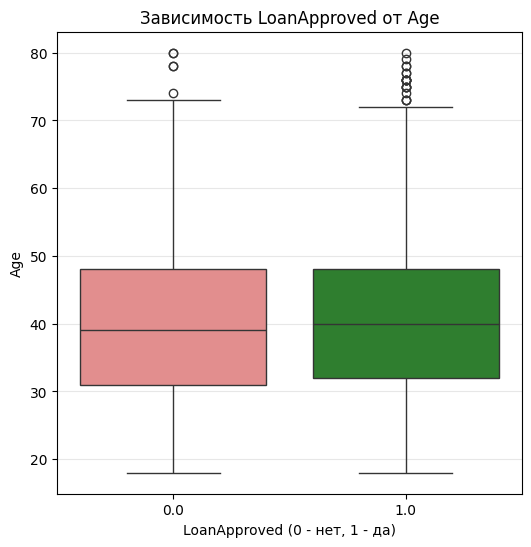

In [139]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=train_df, x='LoanApproved', y='Age',
            hue='LoanApproved',
            palette=['lightcoral', 'forestgreen'],
            legend=False)
plt.title('Зависимость LoanApproved от Age')
plt.xlabel('LoanApproved (0 - нет, 1 - да)')
plt.ylabel('Age')
plt.grid(True, alpha=0.3, axis='y')
plt.show()

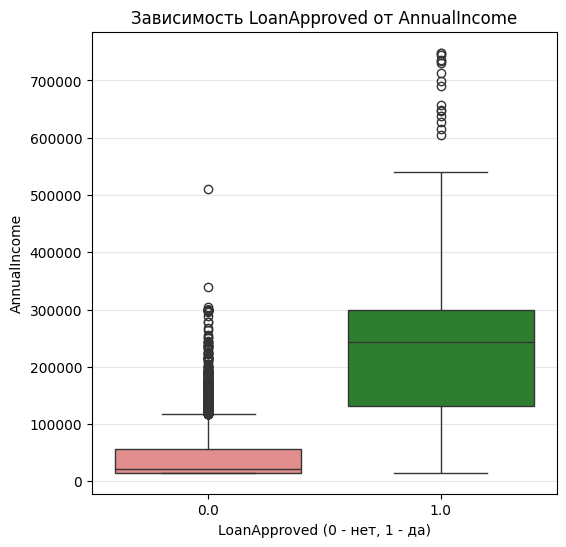

In [140]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=train_df, x='LoanApproved', y='AnnualIncome',
            hue='LoanApproved',
            palette=['lightcoral', 'forestgreen'],
            legend=False)
plt.title('Зависимость LoanApproved от AnnualIncome')
plt.xlabel('LoanApproved (0 - нет, 1 - да)')
plt.ylabel('AnnualIncome')
plt.grid(True, alpha=0.3, axis='y')
plt.show()

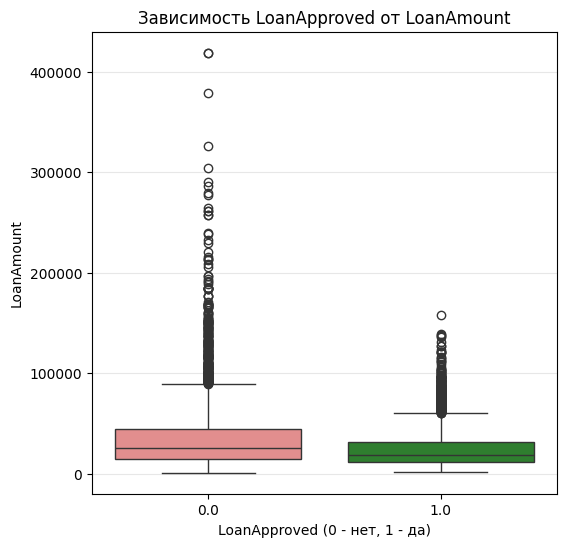

In [141]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=train_df, x='LoanApproved', y='LoanAmount',
            hue='LoanApproved',
            palette=['lightcoral', 'forestgreen'],
            legend=False)
plt.title('Зависимость LoanApproved от LoanAmount')
plt.xlabel('LoanApproved (0 - нет, 1 - да)')
plt.ylabel('LoanAmount')
plt.grid(True, alpha=0.3, axis='y')
plt.show()

# 1. график целевой перменной

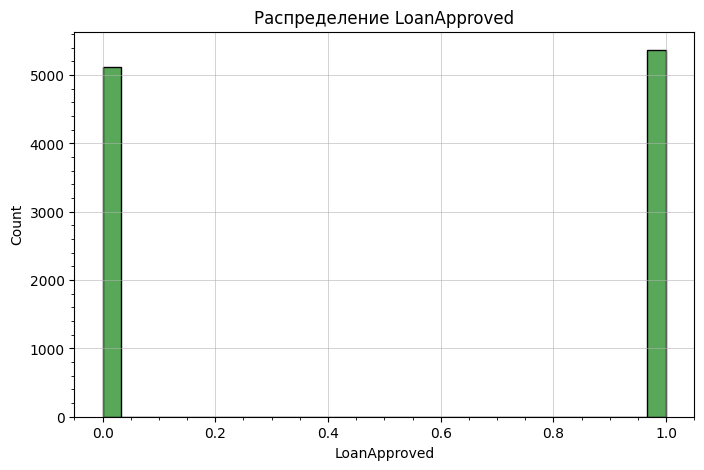

In [142]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df['LoanApproved'], bins=30, color='forestgreen')
plt.title('Распределение LoanApproved')
plt.grid(True, alpha=0.8, linewidth=0.5)
plt.minorticks_on()
plt.show()

# 2. матрица корреляций

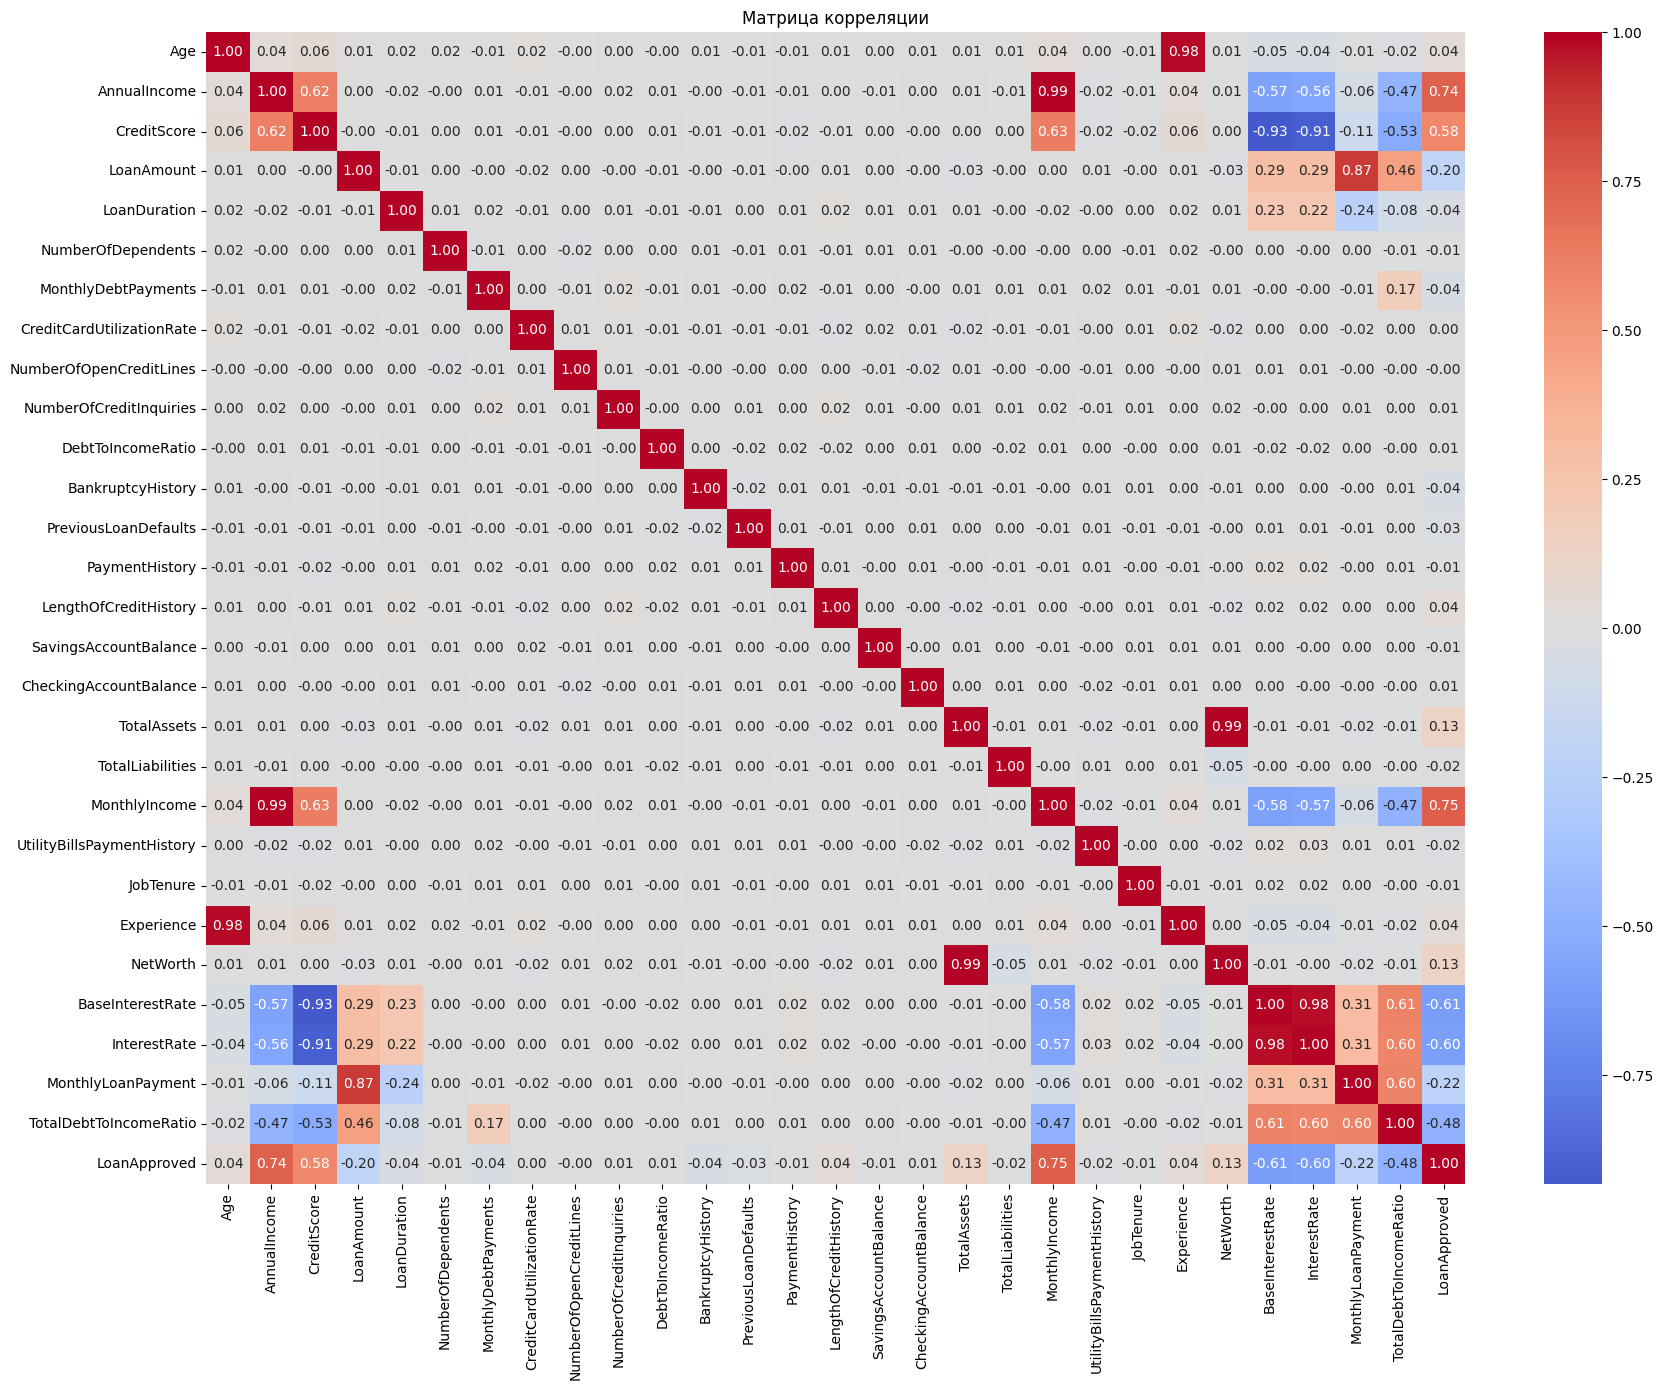

In [143]:
numeric_cols = train_df.select_dtypes(include='number')
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Матрица корреляции")
plt.tight_layout()
plt.show()

In [144]:
numeric_features = train_df.select_dtypes(include=np.number).columns.tolist()
numeric_features.remove("LoanApproved")
print(f"Числовые признаки:")
for num_col in numeric_features:
    print(f"{num_col}")
print(f"Количество числовых признаков: {len(numeric_features)}")

print("\nОсновные статистики числовых признаков:")
print(train_df[numeric_features].describe())

Числовые признаки:
Age
AnnualIncome
CreditScore
LoanAmount
LoanDuration
NumberOfDependents
MonthlyDebtPayments
CreditCardUtilizationRate
NumberOfOpenCreditLines
NumberOfCreditInquiries
DebtToIncomeRatio
BankruptcyHistory
PreviousLoanDefaults
PaymentHistory
LengthOfCreditHistory
SavingsAccountBalance
CheckingAccountBalance
TotalAssets
TotalLiabilities
MonthlyIncome
UtilityBillsPaymentHistory
JobTenure
Experience
NetWorth
BaseInterestRate
InterestRate
MonthlyLoanPayment
TotalDebtToIncomeRatio
Количество числовых признаков: 28

Основные статистики числовых признаков:
                Age   AnnualIncome  CreditScore     LoanAmount  LoanDuration  \
count  10487.000000   10487.000000  9986.000000    9986.000000  10487.000000   
mean      39.850386  131587.872127   678.082716   29874.218306     53.439878   
std       11.614132  115791.941909   175.192486   27705.509722     24.493562   
min       18.000000   15000.000000   300.000000    1063.000000     12.000000   
25%       32.000000   20959.5

In [145]:
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные признаки:")
for cat_col in categorical_features:
    print(f"{cat_col}")
print(f"Количество категориальных признаков: {len(categorical_features)}")

print("\nОсновные статистики категориальных признаков:")
print(train_df[categorical_features].describe())


Категориальные признаки:
ApplicationDate
MaritalStatus
HomeOwnershipStatus
LoanPurpose
EmploymentStatus
EducationLevel
Количество категориальных признаков: 6

Основные статистики категориальных признаков:
       ApplicationDate MaritalStatus HomeOwnershipStatus LoanPurpose  \
count            10487         10487               10487        9986   
unique           10000             4                   4           5   
top         2011-04-20       Married            Mortgage        Home   
freq                 3          5145                4148        2981   

       EmploymentStatus EducationLevel  
count             10487          10487  
unique                3              5  
top            Employed    High School  
freq               9059           4234  


# подготовка данных

In [146]:
def get_iqr_bounds(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound, iqr

for col in numeric_cols:
    lower, upper, iqr = get_iqr_bounds(train_df, col)
    train_df[col] = train_df[col].clip(lower, upper)

заполняем пустые ячейки

In [147]:
print("Пустые ячейки:")
print(train_df.isnull().sum())

Пустые ячейки:
ApplicationDate                530
Age                            530
AnnualIncome                   530
CreditScore                   1031
LoanAmount                    1031
LoanDuration                   530
MaritalStatus                  530
NumberOfDependents             530
HomeOwnershipStatus            530
MonthlyDebtPayments           1031
CreditCardUtilizationRate      530
NumberOfOpenCreditLines        530
NumberOfCreditInquiries        530
DebtToIncomeRatio              530
BankruptcyHistory             1031
LoanPurpose                   1031
PreviousLoanDefaults           530
PaymentHistory                 530
LengthOfCreditHistory          530
SavingsAccountBalance          530
CheckingAccountBalance        1031
TotalAssets                   1031
TotalLiabilities               530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
JobTenure                      530
EmploymentStatus               530
EducationLevel                 530
Exper

In [148]:
print("Пустые ячейки:")
print(test_df.isnull().sum())

Пустые ячейки:
ApplicationDate               0
Age                           0
AnnualIncome                  0
CreditScore                   0
LoanAmount                    0
LoanDuration                  0
MaritalStatus                 0
NumberOfDependents            0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
EmploymentStatus              0
EducationLevel                0
Experience                    0
NetWorth                      0
BaseInterestRate         

In [149]:
train_df = train_df.dropna(subset=['LoanApproved'])

for col in numeric_features:
    if train_df[col].isnull().sum() > 0:
        median_val = train_df[col].median()
        empty = train_df[col].isnull().sum()
        train_df[col] = train_df[col].fillna(median_val)

for col in categorical_features:
    if train_df[col].isnull().sum() > 0:
        mode_values = train_df[col].mode()
        if not mode_values.empty:
            mode_val = mode_values[0]
            empty = train_df[col].isnull().sum()
            train_df[col] = train_df[col].fillna(mode_val)

In [150]:
print("Пустые ячейки:")
print(train_df.isnull().sum())

Пустые ячейки:
ApplicationDate               0
Age                           0
AnnualIncome                  0
CreditScore                   0
LoanAmount                    0
LoanDuration                  0
MaritalStatus                 0
NumberOfDependents            0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
EmploymentStatus              0
EducationLevel                0
Experience                    0
NetWorth                      0
BaseInterestRate         

In [151]:
y_train = train_df['LoanApproved']
X_train = train_df.drop(columns=['LoanApproved', 'ApplicationDate'])
test_df = test_df.drop('ApplicationDate', axis=1)

In [152]:
X_train.head()

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,...,UtilityBillsPaymentHistory,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio
0,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,0.151985,...,0.908289,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013
1,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,0.175693,...,0.797339,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585
2,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,0.444605,...,0.915945,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571
3,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,0.188452,...,0.876416,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415
4,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,0.273431,...,0.888689,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721


кодируем категориальные признаки

In [153]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}

for col in categorical_features:
    encoder = LabelEncoder()

    all_values = pd.concat([X_train[col], test_df[col]], ignore_index=True)
    encoder.fit(all_values)

    X_train[col] = encoder.transform(X_train[col])
    test_df[col] = encoder.transform(test_df[col])

    label_encoders[col] = encoder

In [154]:
X_train.head()

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,...,UtilityBillsPaymentHistory,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio
0,27.0,66829.0,549.0,17290.0,60.0,0,1.0,3,1095.0,0.151985,...,0.908289,4.0,0,0,4.0,35067.0,0.257790,0.251465,508.970230,0.288013
1,55.0,172147.0,850.0,16110.0,36.0,3,1.0,0,211.0,0.175693,...,0.797339,2.0,0,3,33.0,27001.0,0.086110,0.093173,514.675859,0.050585
2,51.0,300000.0,850.0,38436.0,36.0,1,0.0,0,546.0,0.444605,...,0.915945,3.0,0,1,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571
3,25.0,34683.0,847.0,19186.0,48.0,1,0.0,1,153.0,0.188452,...,0.876416,3.0,0,3,0.0,9224.0,0.100686,0.112822,498.505187,0.225415
4,55.0,300000.0,850.0,30437.0,48.0,2,2.0,3,562.0,0.273431,...,0.888689,5.0,0,1,31.0,4502.0,0.110437,0.089037,756.035156,0.052721


# бэггинг

In [155]:
class CustomBaggingClassifier:
    def __init__(self, base_estimator, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.estimators_ = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples = X.shape[0]

        self.estimators_ = []

        for i in range(self.n_estimators):
            # бутстрэп-выборка
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_bootstrap = X.iloc[indices] if hasattr(X, 'iloc') else X[indices]
            y_bootstrap = y.iloc[indices] if hasattr(y, 'iloc') else y[indices]

            # обучаем базовый классификатор
            estimator = clone(self.base_estimator)
            estimator.fit(X_bootstrap, y_bootstrap)

            self.estimators_.append(estimator)
        return self

    def predict(self, X):
        # собираем предсказания всех моделей
        all_predictions = np.array([estimator.predict(X) for estimator in self.estimators_])

        # голосование по большинству
        predictions = []
        for i in range(X.shape[0]):
            # для каждого образца смотрим предсказания всех моделей
            sample_predictions = all_predictions[:, i]

            # находим наиболее частый класс
            unique, counts = np.unique(sample_predictions, return_counts=True)
            majority_class = unique[np.argmax(counts)]

            predictions.append(majority_class)

        return np.array(predictions)

    def predict_proba(self, X):
        # собираем вероятности от всех моделей
        all_proba = [estimator.predict_proba(X) for estimator in self.estimators_
                    if hasattr(estimator, 'predict_proba')]

        if not all_proba:
            raise ValueError("Базовый классификатор должен иметь метод predict_proba")

        # усредняем вероятности
        avg_proba = np.mean(all_proba, axis=0)

        return avg_proba

сравниваем

In [156]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

custom_bagging = CustomBaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=20,
    random_state=42
)

custom_bagging.fit(X_train_split, y_train_split)
y_pred_custom = custom_bagging.predict(X_val)
accuracy_custom = accuracy_score(y_val, y_pred_custom)
print(f"Accuracy (custom): {accuracy_custom:.4f}")

sklearn_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=20,
    random_state=42,
    bootstrap=True
)

sklearn_bagging.fit(X_train_split, y_train_split)
y_pred_sklearn = sklearn_bagging.predict(X_val)
accuracy_sklearn = accuracy_score(y_val, y_pred_sklearn)
print(f"Accuracy (sklearn): {accuracy_sklearn:.4f}")

print(f"Разница в accuracy: {abs(accuracy_custom - accuracy_sklearn):.4f}")

Accuracy (custom): 0.8970
Accuracy (sklearn): 0.9018
Разница в accuracy: 0.0048


# градиентный бустинг

In [157]:
class CustomGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3,
                 subsample=1.0, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.random_state = random_state
        self.estimators_ = []
        self.initial_prediction_ = None

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples = X.shape[0]

        # начальное предсказание (логарифм отношения вероятностей)
        self.initial_prediction_ = np.log(np.mean(y) / (1 - np.mean(y) + 1e-10))
        current_predictions = np.full(n_samples, self.initial_prediction_)

        self.estimators_ = []

        for i in range(self.n_estimators):
            # вычисляем псевдо-остатки (градиент)
            probabilities = self.sigmoid(current_predictions)
            residuals = y - probabilities  # negative gradient for binary cross-entropy

            # выбор подвыборки для обучения
            if self.subsample < 1.0:
                sample_size = int(n_samples * self.subsample)
                sample_idx = np.random.choice(n_samples, sample_size, replace=False)
                X_subset = X.iloc[sample_idx] if hasattr(X, 'iloc') else X[sample_idx]
                residuals_subset = residuals[sample_idx]
            else:
                X_subset = X
                residuals_subset = residuals

            # обучаем дерево на остатках
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=self.random_state + i if self.random_state else None
            )
            tree.fit(X_subset, residuals_subset)

            # обновляем предсказания
            tree_prediction = tree.predict(X)
            current_predictions += self.learning_rate * tree_prediction

            self.estimators_.append(tree)
        return self

    def predict_proba(self, X):
        # начинаем с начального предсказания
        predictions = np.full(X.shape[0], self.initial_prediction_)

        # добавляем вклад каждого дерева
        for tree in self.estimators_:
            predictions += self.learning_rate * tree.predict(X)

        # преобразуем в вероятности
        proba_positive = self.sigmoid(predictions)
        proba_negative = 1 - proba_positive

        return np.column_stack([proba_negative, proba_positive])

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] > 0.5).astype(int)

    def staged_predict_proba(self, X):
        predictions = np.full(X.shape[0], self.initial_prediction_)

        for tree in self.estimators_:
            predictions += self.learning_rate * tree.predict(X)
            proba_positive = self.sigmoid(predictions)
            proba_negative = 1 - proba_positive
            yield np.column_stack([proba_negative, proba_positive])

In [158]:
print("\n1. Custom GradientBoosting:")
custom_gb = CustomGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

custom_gb.fit(X_train_split, y_train_split)
y_pred_custom = custom_gb.predict(X_val)
acc_custom = accuracy_score(y_val, y_pred_custom)
print(f"Accuracy: {acc_custom:.4f}")

print("\n2. Sklearn GradientBoosting:")
sklearn_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

sklearn_gb.fit(X_train_split, y_train_split)
y_pred_sklearn = sklearn_gb.predict(X_val)
acc_sklearn = accuracy_score(y_val, y_pred_sklearn)
print(f"Accuracy: {acc_sklearn:.4f}")

print("\n3. XGBoost:")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_split, y_train_split)
y_pred_xgb = xgb_model.predict(X_val)
acc_xgb = accuracy_score(y_val, y_pred_xgb)
print(f"Accuracy: {acc_xgb:.4f}")


1. Custom GradientBoosting:
Accuracy: 0.9094

2. Sklearn GradientBoosting:
Accuracy: 0.9223

3. XGBoost:
Accuracy: 0.9209


In [159]:
models = {}
results = []

models['Sklearn'] = GradientBoostingClassifier(n_estimators=100, random_state=42)
models['Sklearn'].fit(X_train_split, y_train_split)

models['LightGBM'] = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
models['LightGBM'].fit(X_train_split, y_train_split)


models['XGBoost'] = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
models['XGBoost'].fit(X_train_split, y_train_split)

models['CatBoost'] = cb.CatBoostClassifier(iterations=100, random_seed=42, verbose=False)
models['CatBoost'].fit(X_train_split, y_train_split)

for name, model in models.items():
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'AUC-ROC': roc_auc_score(y_val, y_proba)
    })

results_df = pd.DataFrame(results)
print("\nРезультаты сравнения:")
print(results_df)

best_model_name = results_df.loc[results_df['AUC-ROC'].idxmax(), 'Model']
best_model = models[best_model_name]
print(f"\nЛучшая модель: {best_model_name}")


Результаты сравнения:
      Model  Accuracy   AUC-ROC
0   Sklearn  0.922307  0.977861
1  LightGBM  0.927073  0.978751
2   XGBoost  0.921354  0.978068
3  CatBoost  0.926597  0.978352

Лучшая модель: LightGBM


In [160]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'random_state': 42,
        'verbose': -1
    }

    model = LGBMClassifier(**params)
    model.fit(X_train_split, y_train_split)

    y_proba = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_proba)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print()
print(f"Лучшие параметры: {study.best_params}")
print(f"Лучший AUC-ROC: {study.best_value:.4f}")

[I 2025-12-14 18:40:59,998] A new study created in memory with name: no-name-81744aef-14ec-43d5-8e45-c367331fe47c


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-14 18:41:00,763] Trial 0 finished with value: 0.9779844315818561 and parameters: {'n_estimators': 170, 'learning_rate': 0.18027589544351363, 'max_depth': 9, 'num_leaves': 44, 'min_child_samples': 53, 'subsample': 0.7548361891819024, 'colsample_bytree': 0.6896525692923844, 'reg_alpha': 0.24146137876166318, 'reg_lambda': 0.6826452666378879}. Best is trial 0 with value: 0.9779844315818561.
[I 2025-12-14 18:41:01,565] Trial 1 finished with value: 0.9784979857768211 and parameters: {'n_estimators': 157, 'learning_rate': 0.1891204694699677, 'max_depth': 9, 'num_leaves': 77, 'min_child_samples': 10, 'subsample': 0.7412300235249503, 'colsample_bytree': 0.7991776984700059, 'reg_alpha': 0.9147117961423291, 'reg_lambda': 0.3596060924860045}. Best is trial 1 with value: 0.9784979857768211.
[I 2025-12-14 18:41:01,978] Trial 2 finished with value: 0.9783552813368042 and parameters: {'n_estimators': 105, 'learning_rate': 0.2692006515237958, 'max_depth': 10, 'num_leaves': 24, 'min_child_sam

In [161]:
def custom_accuracy(y_true, y_pred):
    """Accuracy = (TP + TN) / (TP + TN + FP + FN)"""
    correct = np.sum(y_true == y_pred)
    return correct / len(y_true)

def custom_precision(y_true, y_pred):
    """Precision = TP / (TP + FP)"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def custom_recall(y_true, y_pred):
    """Recall = TP / (TP + FN)"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def custom_f1(y_true, y_pred):
    """F1 = 2 * (precision * recall) / (precision + recall)"""
    precision = custom_precision(y_true, y_pred)
    recall = custom_recall(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

custom_acc = custom_accuracy(y_val, y_pred)
custom_prec = custom_precision(y_val, y_pred)
custom_rec = custom_recall(y_val, y_pred)
custom_f1_score = custom_f1(y_val, y_pred)

sklearn_acc = accuracy_score(y_val, y_pred)
sklearn_prec = precision_score(y_val, y_pred, zero_division=0)
sklearn_rec = recall_score(y_val, y_pred, zero_division=0)
sklearn_f1 = f1_score(y_val, y_pred, zero_division=0)

print("Сравнение метрик:")
print(f"{'Метрика':<15} {'Custom':<10} {'Sklearn':<10}")
print("-" * 35)
print(f"{'Accuracy':<15} {custom_acc:.6f}  {sklearn_acc:.6f}")
print(f"{'Precision':<15} {custom_prec:.6f}  {sklearn_prec:.6f}")
print(f"{'Recall':<15} {custom_rec:.6f}  {sklearn_rec:.6f}")
print(f"{'F1-Score':<15} {custom_f1_score:.6f}  {sklearn_f1:.6f}")

Сравнение метрик:
Метрика         Custom     Sklearn   
-----------------------------------
Accuracy        0.926597  0.926597
Precision       0.930057  0.930057
Recall          0.924812  0.924812
F1-Score        0.927427  0.927427


In [164]:
def custom_roc_auc(y_true, y_proba):
    # сортируем по убыванию вероятностей
    sorted_indices = np.argsort(y_proba)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_proba_sorted = y_proba[sorted_indices]

    # вычисляем TPR и FPR для всех порогов
    tpr, fpr = [], []

    # Все уникальные пороги (вероятности)
    thresholds = np.unique(y_proba_sorted)[::-1]
    thresholds = np.append(thresholds, 0)  # добавляем порог 0

    for threshold in thresholds:
        y_pred = (y_proba_sorted >= threshold).astype(int)

        tp = np.sum((y_true_sorted == 1) & (y_pred == 1))
        fp = np.sum((y_true_sorted == 0) & (y_pred == 1))
        tn = np.sum((y_true_sorted == 0) & (y_pred == 0))
        fn = np.sum((y_true_sorted == 1) & (y_pred == 0))

        tpr_val = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr.append(tpr_val)
        fpr.append(fpr_val)

    # вычисляем площадь методом трапеций
    auc = 0
    for i in range(1, len(fpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2

    return auc

def custom_average_precision(y_true, y_proba):
    # сортируем по убыванию вероятностей
    sorted_indices = np.argsort(y_proba)[::-1]
    y_true_sorted = y_true[sorted_indices]

    # вычисляем precision и recall на каждом шаге
    tp_cumsum = np.cumsum(y_true_sorted)
    fp_cumsum = np.cumsum(1 - y_true_sorted)

    precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-10)
    recall = tp_cumsum / (np.sum(y_true) + 1e-10)

    # метод трапеций для вычисления площади
    ap = 0
    for i in range(1, len(recall)):
        ap += (recall[i] - recall[i-1]) * precision[i]

    return ap

custom_auc = custom_roc_auc(y_pred, y_proba)
custom_ap = custom_average_precision(y_pred, y_proba)

sklearn_auc = roc_auc_score(y_pred, y_proba)
sklearn_ap = average_precision_score(y_pred, y_proba)

print("Сравнение AUC метрик:")
print(f"{'Метрика':<15} {'Наша':<10} {'Sklearn':<10} {'Разница':<10}")
print("-" * 45)
print(f"{'AUC-ROC':<15} {custom_auc:.6f}  {sklearn_auc:.6f}  {abs(custom_auc - sklearn_auc):.6f}")
print(f"{'AUC-PR':<15} {custom_ap:.6f}  {sklearn_ap:.6f}  {abs(custom_ap - sklearn_ap):.6f}")

Сравнение AUC метрик:
Метрика         Наша       Sklearn    Разница   
---------------------------------------------
AUC-ROC         1.000000  1.000000  0.000000
AUC-PR          0.999055  1.000000  0.000945


In [163]:
model = CatBoostClassifier(verbose=0, random_state=42)
model.fit(X_train, y_train)

proba = model.predict_proba(test_df)[:, 1]

result = pd.DataFrame({
    'ID': test_ids,
    'LoanApproved': proba,
})

result.to_csv('predictions.csv', index=False)
print(f"\nФайл сохранён: predictions.csv")


Файл сохранён: predictions.csv
